In [1]:
import spacy
import textdescriptives as td
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import matplotlib.pyplot as plt

nlp = spacy.load("de_core_news_lg")

In [2]:
nlp.add_pipe("textdescriptives/all")

In [11]:
import sklearn
import os
# Load speeches and labels from dataset
def load_data(dataset_path):
    speeches = []
    labels = []
    allcols = []
    for author_id, author_folder in enumerate(os.listdir(dataset_path)):
        author_path = os.path.join(dataset_path, author_folder)
        if not os.path.isdir(author_path):
            continue
        for file_name in os.listdir(author_path):
            # check if author_path is a directory
            if not os.path.isdir(file_name):
                continue
            file_path = os.path.join(author_path, file_name)
            with open(file_path, "r", encoding="utf-8") as infile:
                text = infile.read()
                print(text[:100])
                doc = nlp(text)
                style=td.extract_df(doc)
                del style[style.columns[0]]
                speeches.append(style.values[0])
                allcols=style.keys()  # well once would be suffficent
                labels.append(author_id)
    return speeches, labels, allcols

In [14]:
X, y, allcols = load_data('../../data/20min/continue')

UnboundLocalError: local variable 'allcols' referenced before assignment

In [10]:
def learn(X,y):
    s=MinMaxScaler().fit(X)
    X=s.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

    model=LogisticRegression(max_iter=1000, random_state=2)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)
    print(classification_report(y_pred, y_test))
    return model,X_train,X_test,y_test

model,X_train,X_test,y_test=learn(X,y)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

def learn2(X,y):
    s=MinMaxScaler().fit(X)
    X=s.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
    model = DecisionTreeClassifier(criterion='log_loss',random_state=0)                           
    #model=LogisticRegression(max_iter=1000, random_state=2)
    #model = RandomForestClassifier(max_depth=52, random_state=0)
    #model = GradientBoostingClassifier(n_estimators=100, max_depth=1, random_state=0).fit(X_train, y_train)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)
    print(classification_report(y_pred, y_test))
    return model,X_train,X_test,y_test


model,X_train,X_test,y_test=learn2(X,y)


              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.92      1.00      0.96        22

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



[Text(0.4, 0.8333333333333334, 'x[64] <= 0.671\nlog_loss = 1.0\nsamples = 150\nvalue = [74, 76]'),
 Text(0.2, 0.5, 'log_loss = 0.0\nsamples = 73\nvalue = [73, 0]'),
 Text(0.6, 0.5, 'x[43] <= 0.665\nlog_loss = 0.1\nsamples = 77\nvalue = [1, 76]'),
 Text(0.4, 0.16666666666666666, 'log_loss = 0.0\nsamples = 76\nvalue = [0, 76]'),
 Text(0.8, 0.16666666666666666, 'log_loss = 0.0\nsamples = 1\nvalue = [1, 0]')]

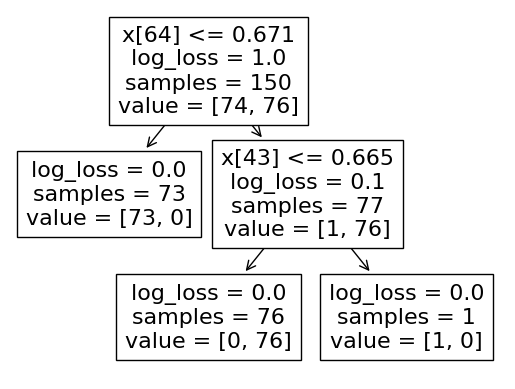

In [6]:
from sklearn import tree
tree.plot_tree(model)

In [7]:
print("the features used by dectree:",allcols[49],allcols[62])

the features used by dectree: dependency_distance_mean n_tokens


In [9]:
# call logistic regression again
model,X_train,X_test,y_test=learn(X,y)

explainer = shap.Explainer(model, X_train, feature_names=allcols)

shap_values = explainer(X_test)

shap_values

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.96      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



.values =
array([[ 7.15475657e-03,  1.55303725e-04,  1.56594037e-04, ...,
         2.35924627e-02,  5.81390539e-02,  5.51942807e-02],
       [ 1.76719104e-02,  1.58184686e-04,  1.59825080e-04, ...,
        -1.59922063e-02, -4.00099458e-02, -3.76523504e-02],
       [ 7.11983815e-02,  1.65332154e-04,  1.69014682e-04, ...,
        -1.58338676e-04,  1.36831519e-01,  2.36544921e-01],
       ...,
       [ 1.96387904e-02,  1.58645623e-04,  1.60165866e-04, ...,
        -1.20337394e-02,  8.83935046e-02,  1.44263772e-01],
       [ 5.50256693e-02,  1.64052614e-04,  1.67167186e-04, ...,
         7.75859513e-03,  6.08533202e-02,  9.88324601e-02],
       [-2.65780933e-01, -1.01753857e-02, -7.40153664e-03, ...,
         1.93806540e-01,  1.87128205e-01,  2.97569748e-01]])

.base_values =
array([-0.45655688, -0.45655688, -0.45655688, -0.45655688, -0.45655688,
       -0.45655688, -0.45655688, -0.45655688, -0.45655688, -0.45655688,
       -0.45655688, -0.45655688, -0.45655688, -0.45655688, -0.45655688,
 

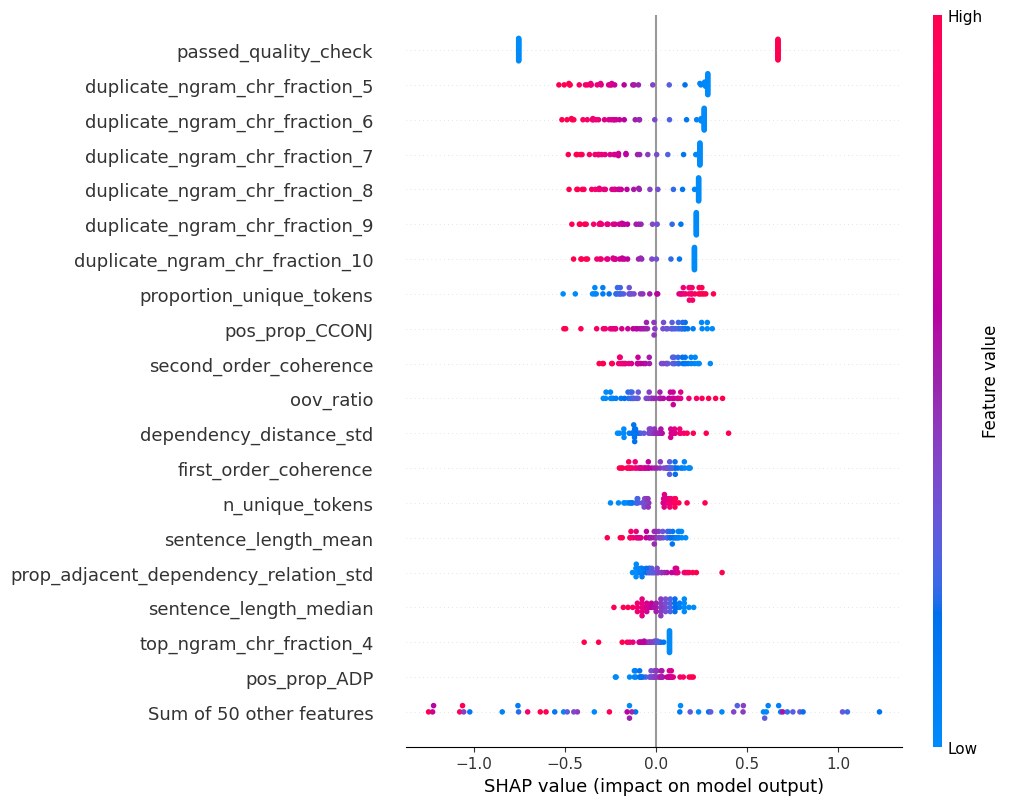

In [10]:
shap.plots.beeswarm(shap_values, max_display=20)